In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

try:
    import umap  # pip install umap-learn  
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False

In [2]:
# Настройки отображения
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [ ]:
# Считываем датасет с Kaggle
df = pd.read_csv('data/EEG-Eye-State.csv')
df

AF3      AF4       F3       F4       F7       F8      FC5      FC6  \
0      4329.23  4393.85  4289.23  4280.51  4009.23  4635.90  4148.21  4211.28   
1      4324.62  4384.10  4293.85  4279.49  4004.62  4632.82  4148.72  4207.69   
2      4327.69  4389.23  4295.38  4282.05  4006.67  4628.72  4156.41  4206.67   
3      4328.72  4396.41  4296.41  4287.69  4011.79  4632.31  4155.90  4210.77   
4      4326.15  4398.46  4292.31  4288.21  4011.79  4632.82  4151.28  4212.82   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14975  4281.03  4340.51  4245.64  4269.23  3990.26  4593.33  4116.92  4171.28   
14976  4276.92  4333.33  4245.13  4259.49  3991.79  4590.26  4110.77  4162.56   
14977  4277.44  4339.49  4246.67  4257.95  3990.77  4591.79  4113.85  4160.51   
14978  4284.62  4350.77  4251.28  4267.18  3991.79  4596.41  4122.05  4165.64   
14979  4287.69  4350.77  4260.00  4274.36  3997.44  4597.95  4121.03  4167.69   

            T7       T8       P7       P8       O1       O2  eyeDetection  
0      4350.26  4238.46  4586.15  4222.05  4096.92  4641.03             0  
1      4342.05  4226.67  4586.67  4210.77  4097.44  4638.97             0  
2      4336.92  4222.05  4583.59  4207.69  4096.92  4630.26             0  
3      4343.59  4235.38  4582.56  4217.44  4097.44  4630.77             0  
4      4347.69  4244.10  4586.67  4210.77  4095.90  4627.69             0  
...        ...      ...      ...      ...      ...      ...           ...  
14975  4333.85  4221.54  4614.36  4203.08  4074.87  4625.64             1  
14976  4332.82  4217.44  4615.38  4194.36  4073.33  4621.54             1  
14977  4333.33  4212.82  4615.38  4193.33  4072.82  4623.59             1  
14978  4334.36  4220.00  4616.41  4200.00  4080.51  4628.72             1  
14979  4333.33  4226.67  4616.41  4212.31  4088.72  4638.46             1  

[14980 rows x 15 columns]

In [4]:
df.describe()

AF3            AF4            F3            F4            F7  \
count   14980.000000   14980.000000  14980.000000  14980.000000  14980.000000   
mean     4321.917777    4416.435832   4264.022433   4279.232774   4009.767694   
std      2492.072174    5891.285043     44.428052     41.544312     45.941672   
min      1030.770000    1366.150000   1040.000000   2257.950000   2830.770000   
25%      4280.510000    4342.050000   4250.260000   4267.690000   3990.770000   
50%      4294.360000    4354.870000   4262.560000   4276.920000   4005.640000   
75%      4311.790000    4372.820000   4270.770000   4287.180000   4023.080000   
max    309231.000000  715897.000000   6880.510000   7002.560000   7804.620000   

                  F8            FC5           FC6            T7            T8  \
count   14980.000000   14980.000000  14980.000000  14980.000000  14980.000000   
mean     4615.205336    4164.946326   4202.456900   4341.741075   4231.316200   
std      1208.369958    5216.404632     37.785981     34.738821     38.050903   
min        86.666700    2453.330000   3273.330000   2089.740000   1816.410000   
25%      4590.770000    4108.210000   4190.260000   4331.790000   4220.510000   
50%      4603.080000    4120.510000   4200.510000   4338.970000   4229.230000   
75%      4617.440000    4132.310000   4211.280000   4347.180000   4239.490000   
max    152308.000000  642564.000000   6823.080000   6474.360000   6674.360000   

                  P7             P8             O1            O2  eyeDetection  
count   14980.000000   14980.000000   14980.000000  14980.000000  14980.000000  
mean     4644.022379    4218.826610    4110.400160   4616.056904      0.448798  
std      2924.789537    2136.408523    4600.926543     29.292603      0.497388  
min      2768.210000    1357.950000    2086.150000   4567.180000      0.000000  
25%      4611.790000    4190.770000    4057.950000   4604.620000      0.000000  
50%      4617.950000    4199.490000    4070.260000   4613.330000      0.000000  
75%      4626.670000    4209.230000    4083.590000   4624.100000      1.000000  
max    362564.000000  265641.000000  567179.000000   7264.100000      1.000000

### В данных есть выбросы, которые на несколько порядков больше других данных. Необходимо их убрать, например, с помощью квантилей.

In [5]:
q = 0.999

feature_names = [x for x in df.columns if x != 'eyeDetection']
for feature in feature_names:
    df = df[df[feature] < df[feature].quantile(q)]
df

AF3      AF4       F3       F4       F7       F8      FC5      FC6  \
0      4329.23  4393.85  4289.23  4280.51  4009.23  4635.90  4148.21  4211.28   
1      4324.62  4384.10  4293.85  4279.49  4004.62  4632.82  4148.72  4207.69   
2      4327.69  4389.23  4295.38  4282.05  4006.67  4628.72  4156.41  4206.67   
3      4328.72  4396.41  4296.41  4287.69  4011.79  4632.31  4155.90  4210.77   
4      4326.15  4398.46  4292.31  4288.21  4011.79  4632.82  4151.28  4212.82   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14975  4281.03  4340.51  4245.64  4269.23  3990.26  4593.33  4116.92  4171.28   
14976  4276.92  4333.33  4245.13  4259.49  3991.79  4590.26  4110.77  4162.56   
14977  4277.44  4339.49  4246.67  4257.95  3990.77  4591.79  4113.85  4160.51   
14978  4284.62  4350.77  4251.28  4267.18  3991.79  4596.41  4122.05  4165.64   
14979  4287.69  4350.77  4260.00  4274.36  3997.44  4597.95  4121.03  4167.69   

            T7       T8       P7       P8       O1       O2  eyeDetection  
0      4350.26  4238.46  4586.15  4222.05  4096.92  4641.03             0  
1      4342.05  4226.67  4586.67  4210.77  4097.44  4638.97             0  
2      4336.92  4222.05  4583.59  4207.69  4096.92  4630.26             0  
3      4343.59  4235.38  4582.56  4217.44  4097.44  4630.77             0  
4      4347.69  4244.10  4586.67  4210.77  4095.90  4627.69             0  
...        ...      ...      ...      ...      ...      ...           ...  
14975  4333.85  4221.54  4614.36  4203.08  4074.87  4625.64             1  
14976  4332.82  4217.44  4615.38  4194.36  4073.33  4621.54             1  
14977  4333.33  4212.82  4615.38  4193.33  4072.82  4623.59             1  
14978  4334.36  4220.00  4616.41  4200.00  4080.51  4628.72             1  
14979  4333.33  4226.67  4616.41  4212.31  4088.72  4638.46             1  

[14760 rows x 15 columns]

In [9]:
df.describe()

AF3           AF4            F3            F4            F7  \
count  14760.000000  14760.000000  14760.000000  14760.000000  14760.000000   
mean    4299.809106   4359.658411   4262.961930   4277.931711   4008.462131   
std       35.473707     36.013527     18.991537     17.608417     28.562678   
min     4197.950000   4205.640000   4197.440000   4201.030000   3905.640000   
25%     4280.510000   4341.540000   4250.260000   4267.180000   3990.260000   
50%     4293.850000   4354.870000   4262.560000   4276.410000   4005.130000   
75%     4310.260000   4371.790000   4270.260000   4286.670000   4022.050000   
max     4490.260000   4535.900000   4367.690000   4364.100000   4140.510000   

                 F8           FC5           FC6            T7            T8  \
count  14760.000000  14760.000000  14760.000000  14760.000000  14760.000000   
mean    4604.437060   4121.368542   4200.786828   4340.641390   4230.153348   
std       30.678969     18.851415     21.674630     14.247183     17.214716   
min     4443.080000   4058.460000   4100.000000   4304.620000   4152.820000   
25%     4590.260000   4108.210000   4189.740000   4331.790000   4220.000000   
50%     4603.080000   4120.510000   4200.000000   4338.970000   4229.230000   
75%     4616.920000   4131.280000   4210.770000   4346.670000   4239.490000   
max     4774.360000   4213.330000   4306.670000   4428.720000   4312.310000   

                 P7            P8            O1            O2  eyeDetection  
count  14760.000000  14760.000000  14760.000000  14760.000000  14760.000000  
mean    4619.094776   4200.434656   4071.940484   4614.900810      0.450474  
std       15.228522     15.549795     19.172849     16.136764      0.497558  
min     4566.150000   4147.690000   4026.150000   4567.180000      0.000000  
25%     4611.790000   4190.770000   4057.950000   4604.620000      0.000000  
50%     4617.950000   4199.490000   4070.260000   4613.330000      0.000000  
75%     4626.150000   4208.720000   4083.590000   4623.590000      1.000000  
max     4705.130000   4274.360000   4155.380000   4686.150000      1.000000

### Теперь выбросов нет, можно работать с данными

In [6]:
df['eyeDetection'].value_counts()

eyeDetection
0    8111
1    6649
Name: count, dtype: int64

### Датасет сбалансирован относительно таргета

In [7]:
# На Kaggle для датасета указано, что 0 - это Closed (глаз закрыт), а 1 - Open Eyes (глаз открыт)
target_class_names_dict = {
    0: 'Closed',
    1: 'Open Eyes'
}


Информация о данных:
  Размер: (14760, 14)
  Количество классов: 2
  Количество признаков: 14
  Минимум: -5.260, Максимум: 6.182
  Среднее: -0.000, Стандартное отклонение: 1.000
ПОЛНАЯ ВИЗУАЛИЗАЦИЯ МНОГОМЕРНЫХ ДАННЫХ

1. Парные диаграммы рассеяния (PairPlot)


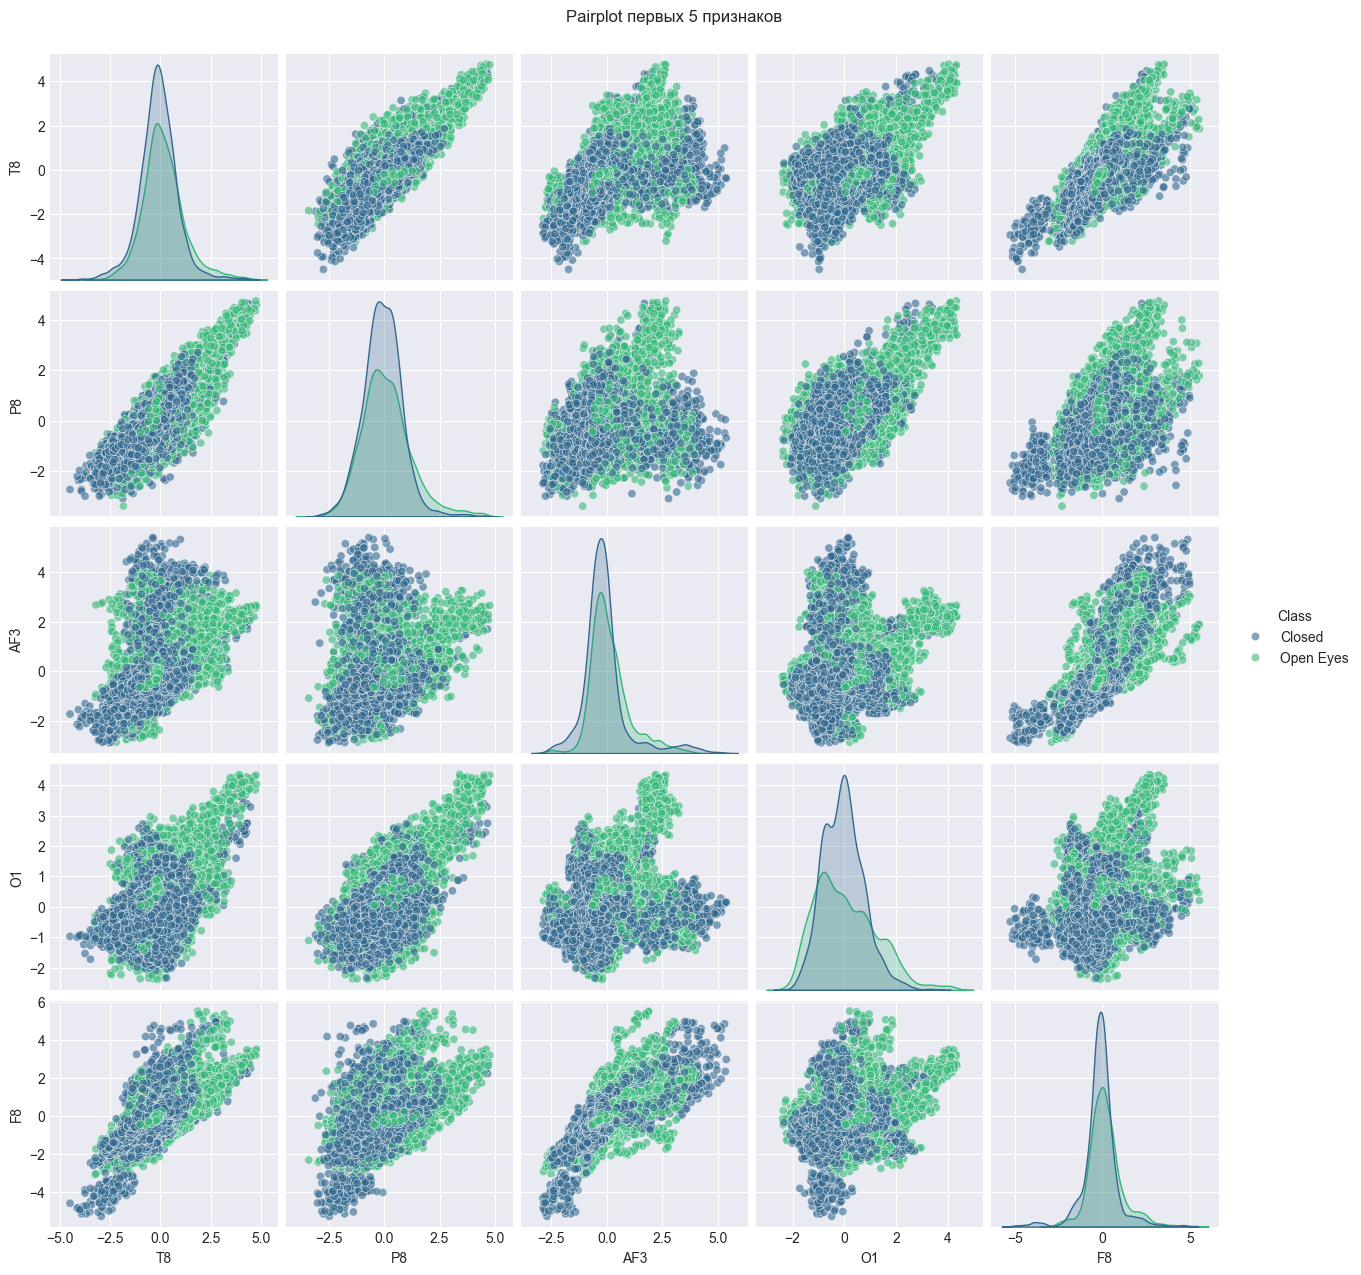


2. Тепловая карта корреляций


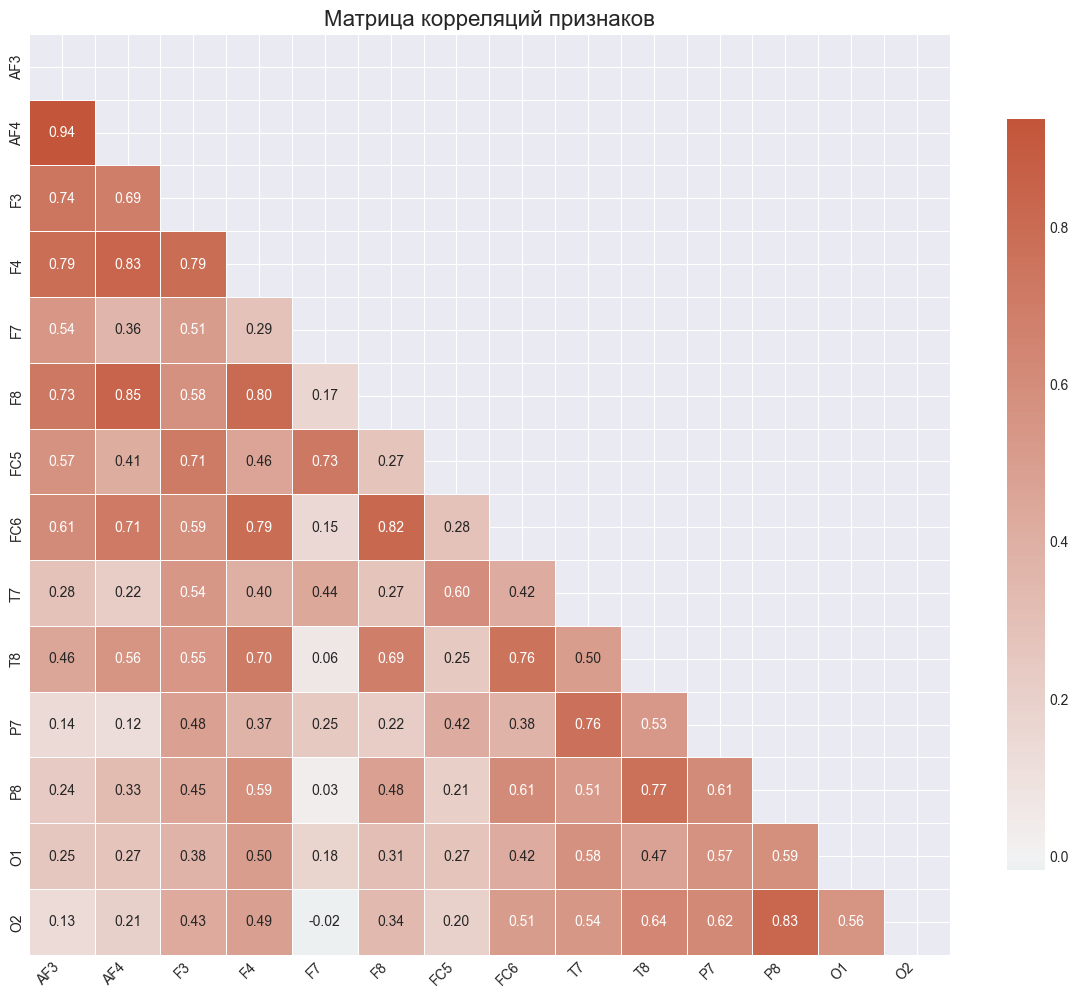


3. Визуализация PCA (2D и 3D)
Объясненная дисперсия: [0.52430889 0.16607133 0.1327875 ]
Суммарная объясненная дисперсия: 0.823


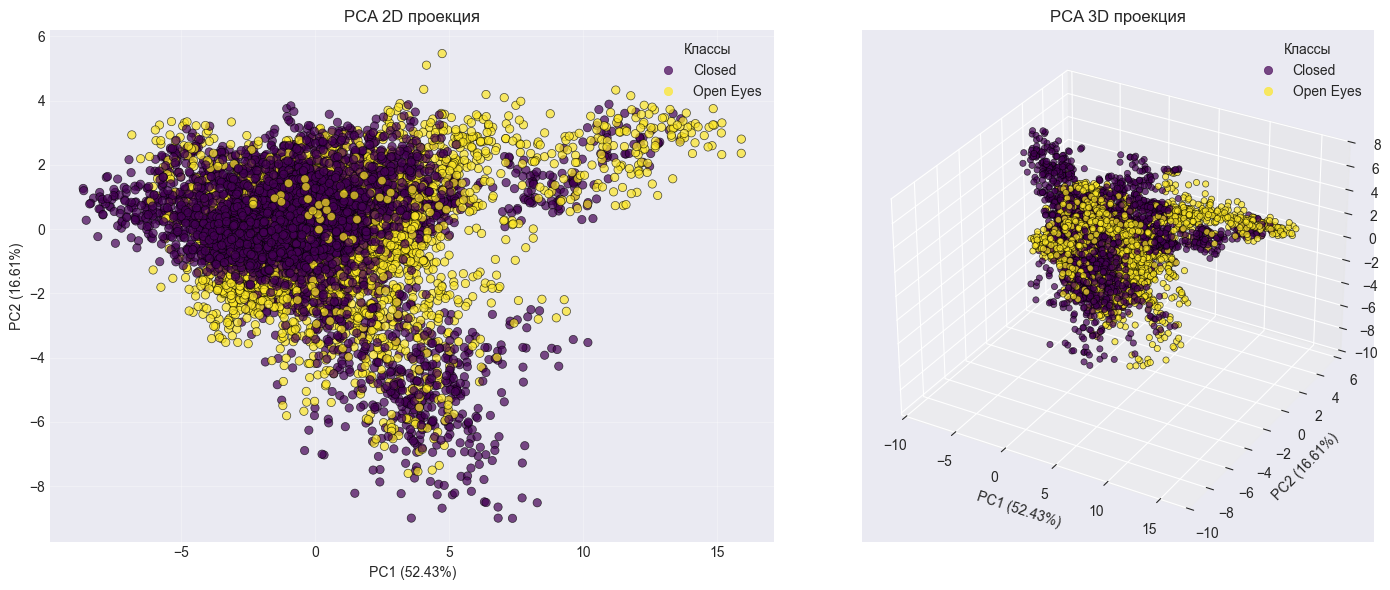

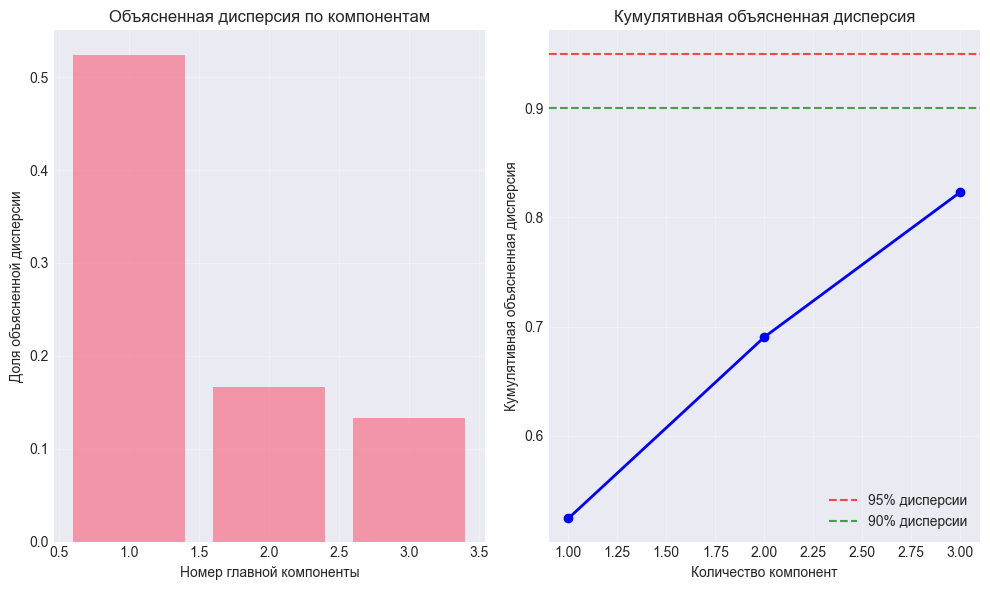


4. Визуализация t-SNE


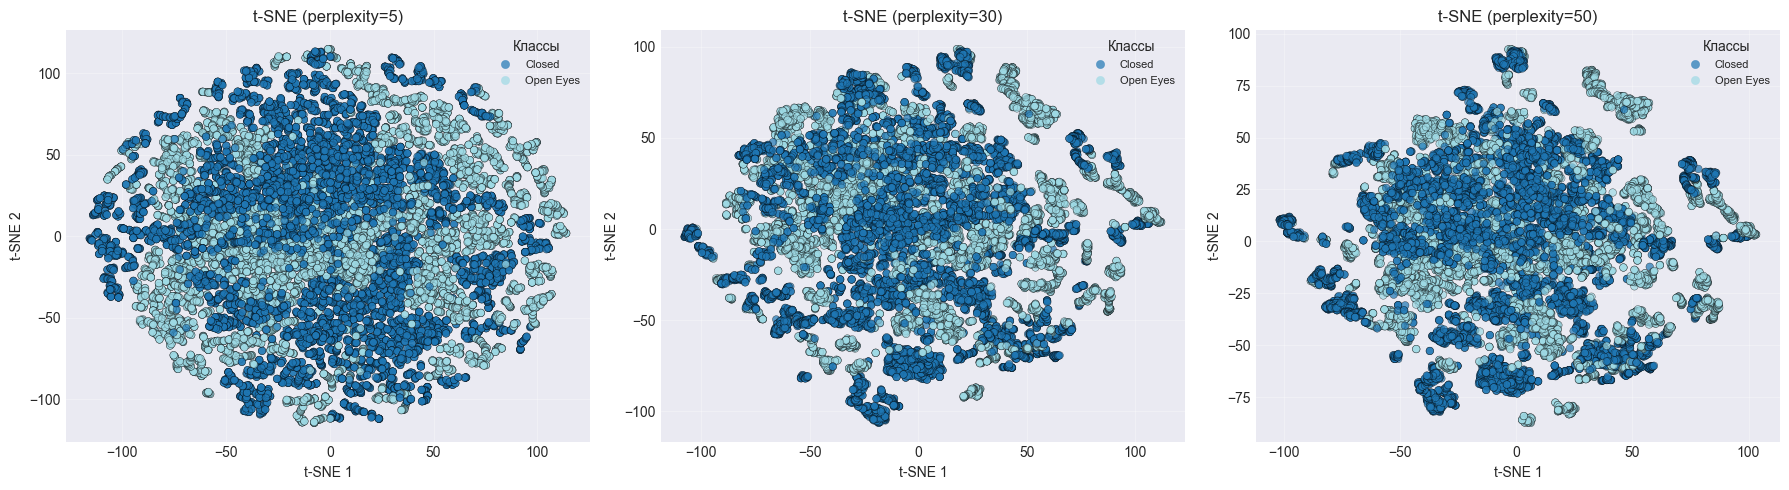


5. Визуализация UMAP


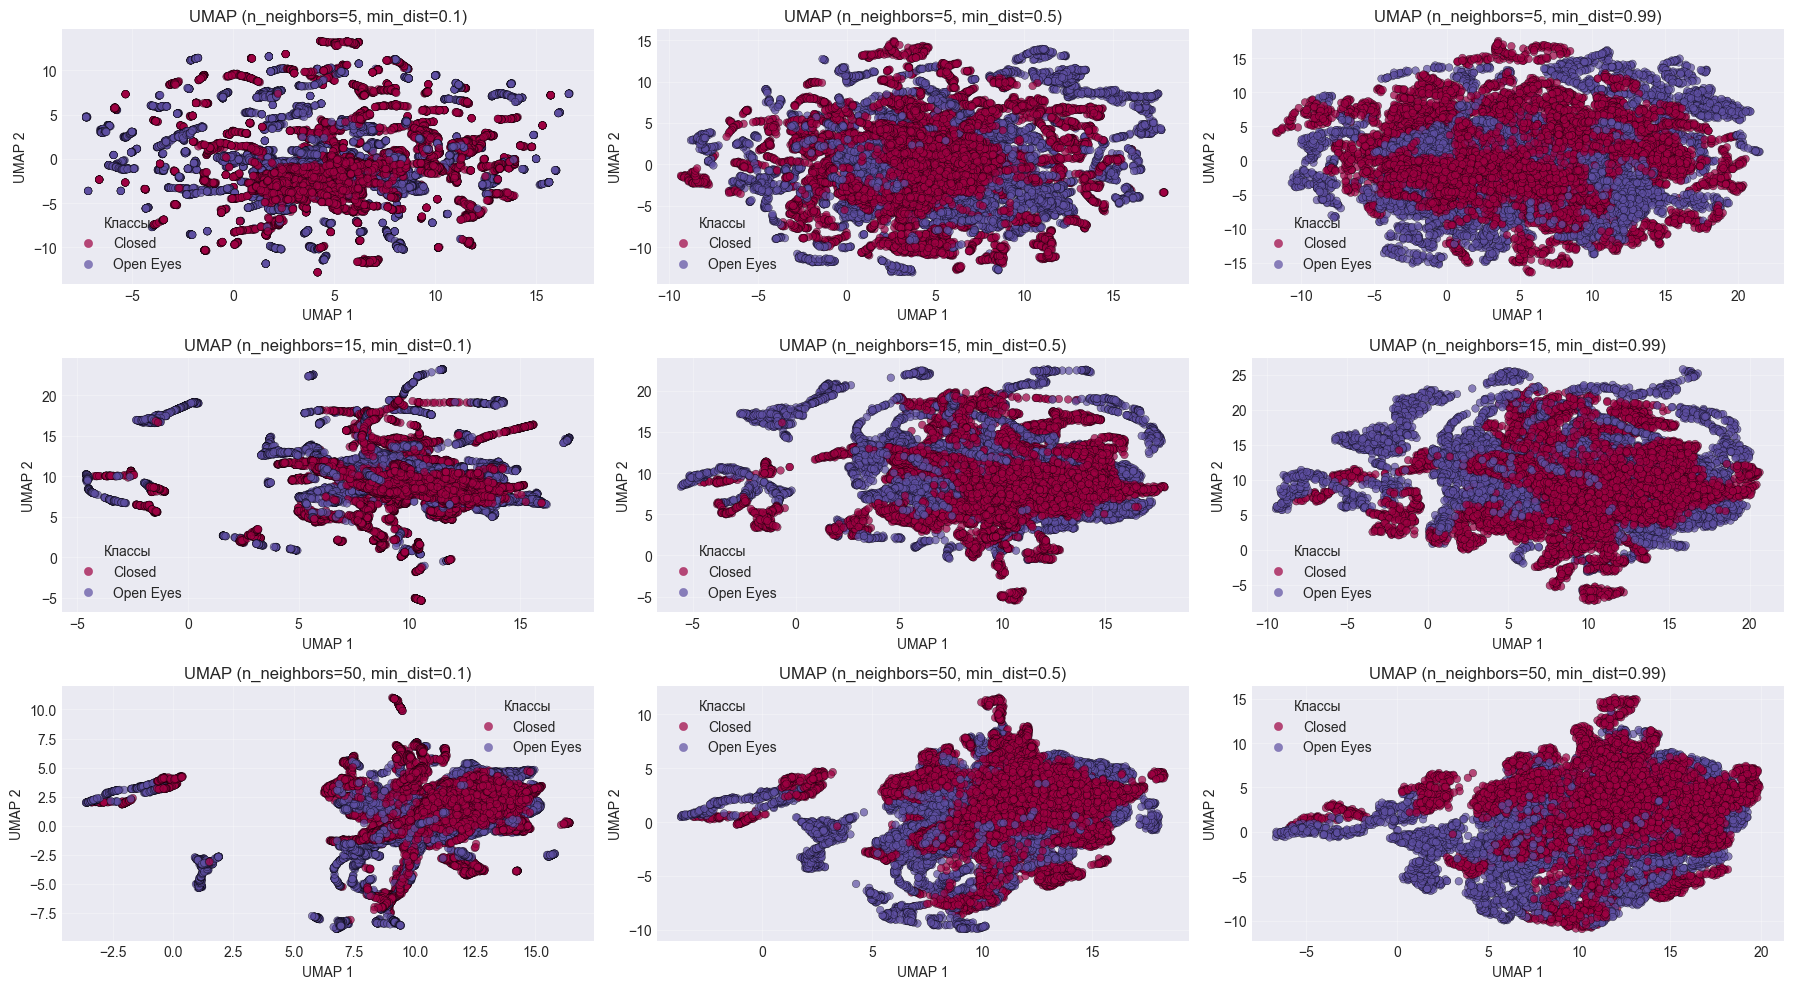


6. Параллельные координаты


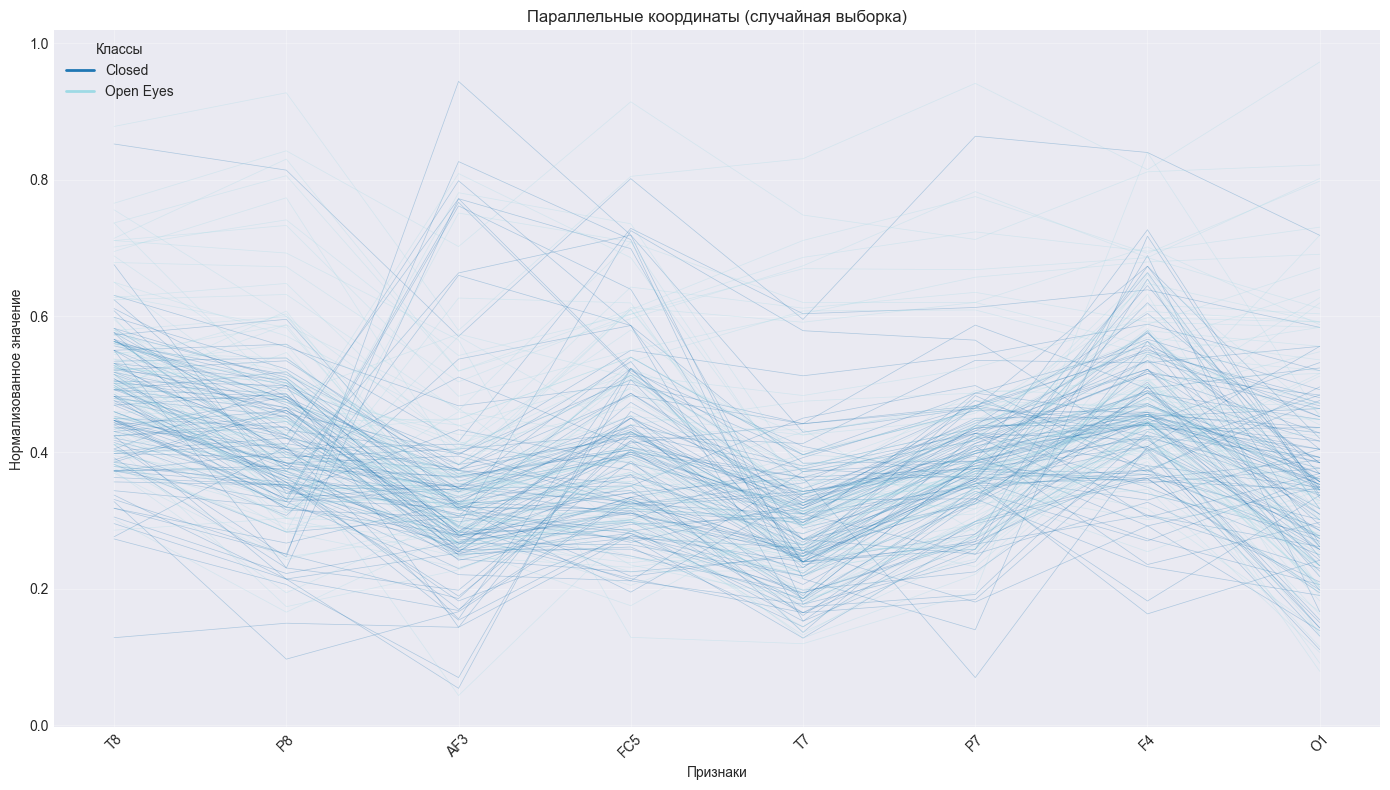


7. Радар-чарты по классам


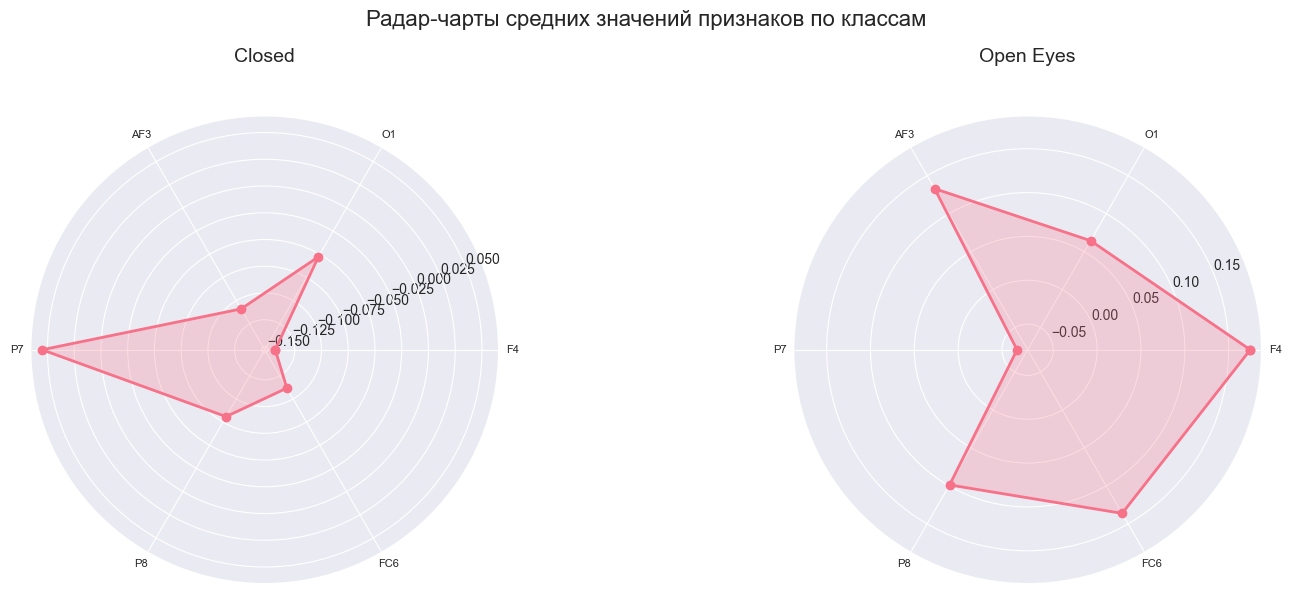


8. Интерактивная 3D визуализация (откроется в браузере)
  График сохранен в файл: interactive_3d_plot.html



9. Сравнение методов уменьшения размерности
  Применяем PCA...
  Применяем t-SNE...
  Применяем Isomap...
  Применяем UMAP...


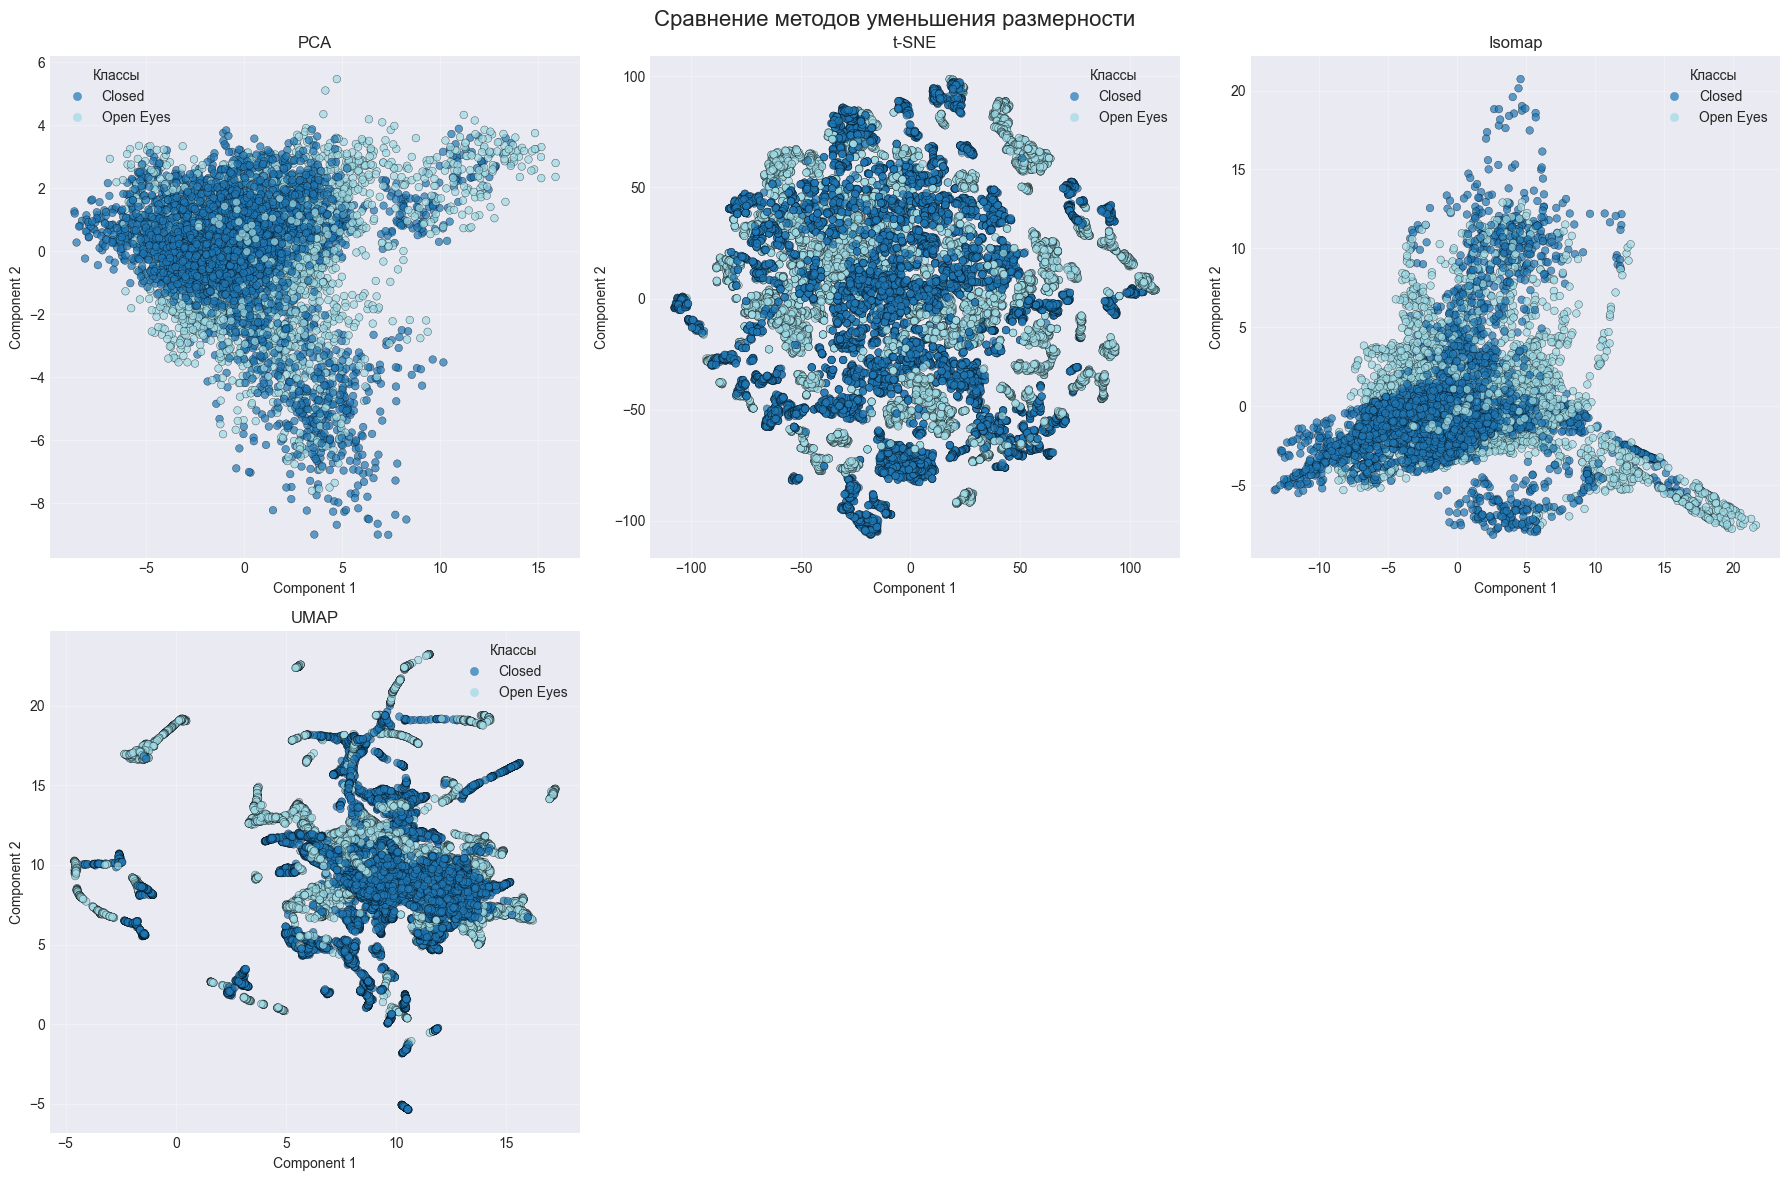


ВИЗУАЛИЗАЦИЯ ЗАВЕРШЕНА


In [8]:
from multidim_visualization import HighDimVisualizer

visualizer = HighDimVisualizer(random_state=42)

# Загрузка датасета и других параметров в визуализатор
# StandardScaler() добавлен для того, чтобы в радар-чартах была видна разница между классами, так как данные находятся примерно в диапазоне 1000-7000
visualizer.load_dataset(df, target_column='eyeDetection', scaler=StandardScaler(), target_class_names=target_class_names_dict)

# Запуск визуализации
visualizer.run_full_visualization()